## 网络层

#### torch.nn下有多种已经实现好了的网络层。对于每一个类别，比较重要的是三个点：1、怎么层是什么意思，怎么理解这个层。2、类实例化的参数分别是什么意思，怎么理解这些参数。3、模型的权重、偏置这些训练参数是按照什么原则进行自动初始化的，如何得到我们想要的初始化参数
#### 根据官网介绍，可以分为如下几类：

##### 注意！下面的1d/2d/3d指的是去掉batch_size和channel两个维度之后，数据剩下的维度。如果是文字应该只剩1个维度，所以要用1d,如果是照片就还剩2个维度，即照片的高和宽，所以要用2d,如果是三位模型就还剩3个维度，所以要用3d



<div>
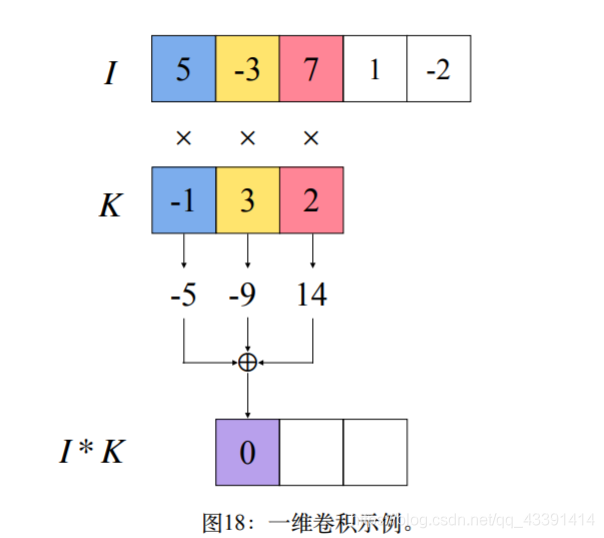
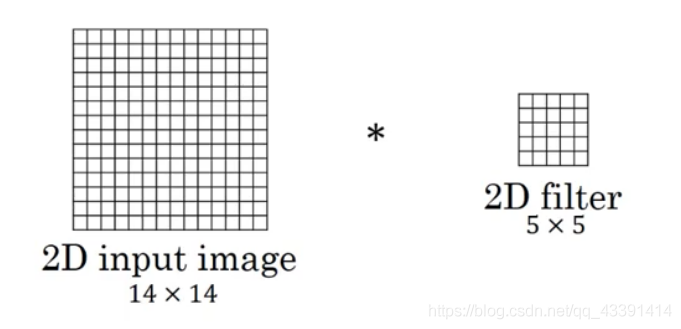
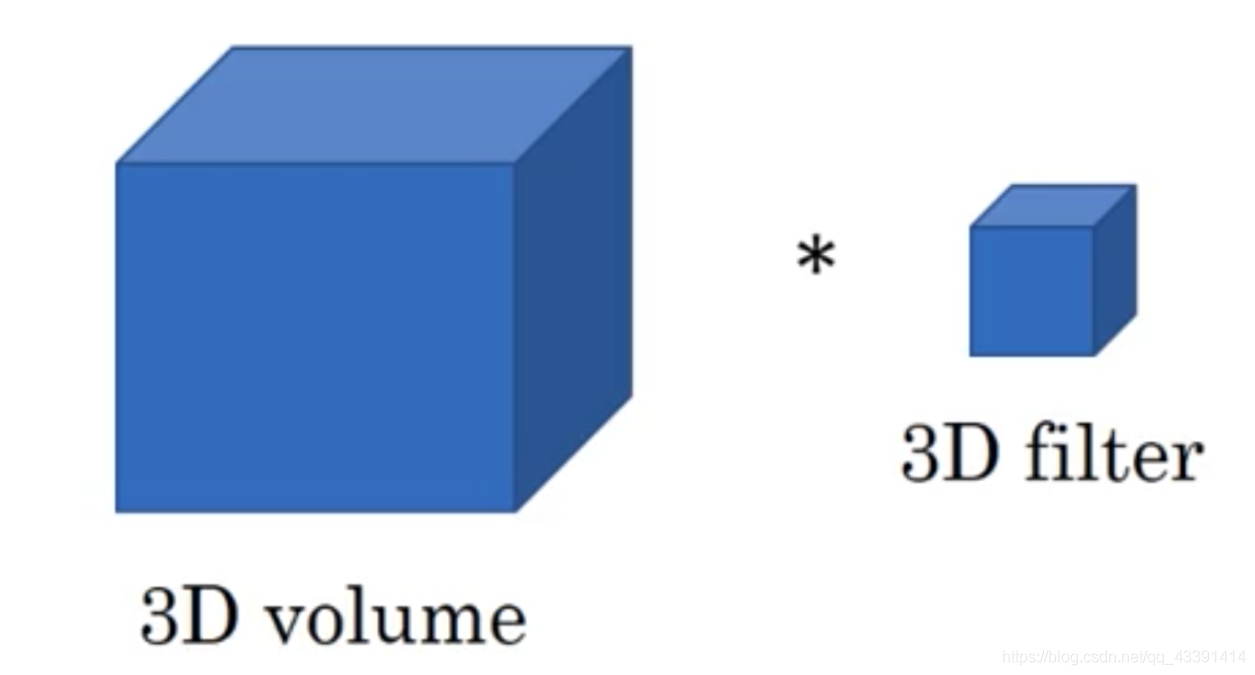
</div>

#### 1）卷积层（Convolution Layers）：
Conv1d/2d/3d 
###### 卷积
ConvTranspose1d/2d/3d 
###### 反向卷积，增大数据维度
<div>
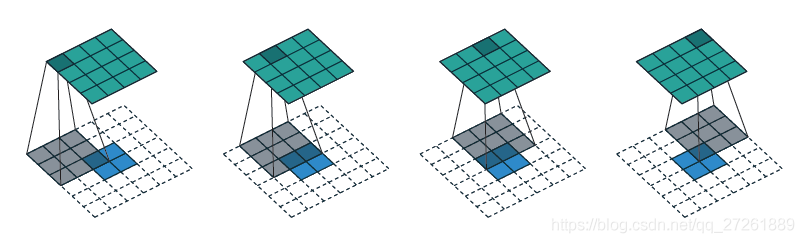
</div>

LazyConv1d/2d/3d 
###### 不用输入input维度的Conv1d/2d/3d，input的维度由模型从后面传入的input_data.shape[1]获取
LazyConvTranspose1d/2d/3d 
###### 同上
Fold/Unfold 
###### 按卷积核维度摊平或折叠数据
<div>
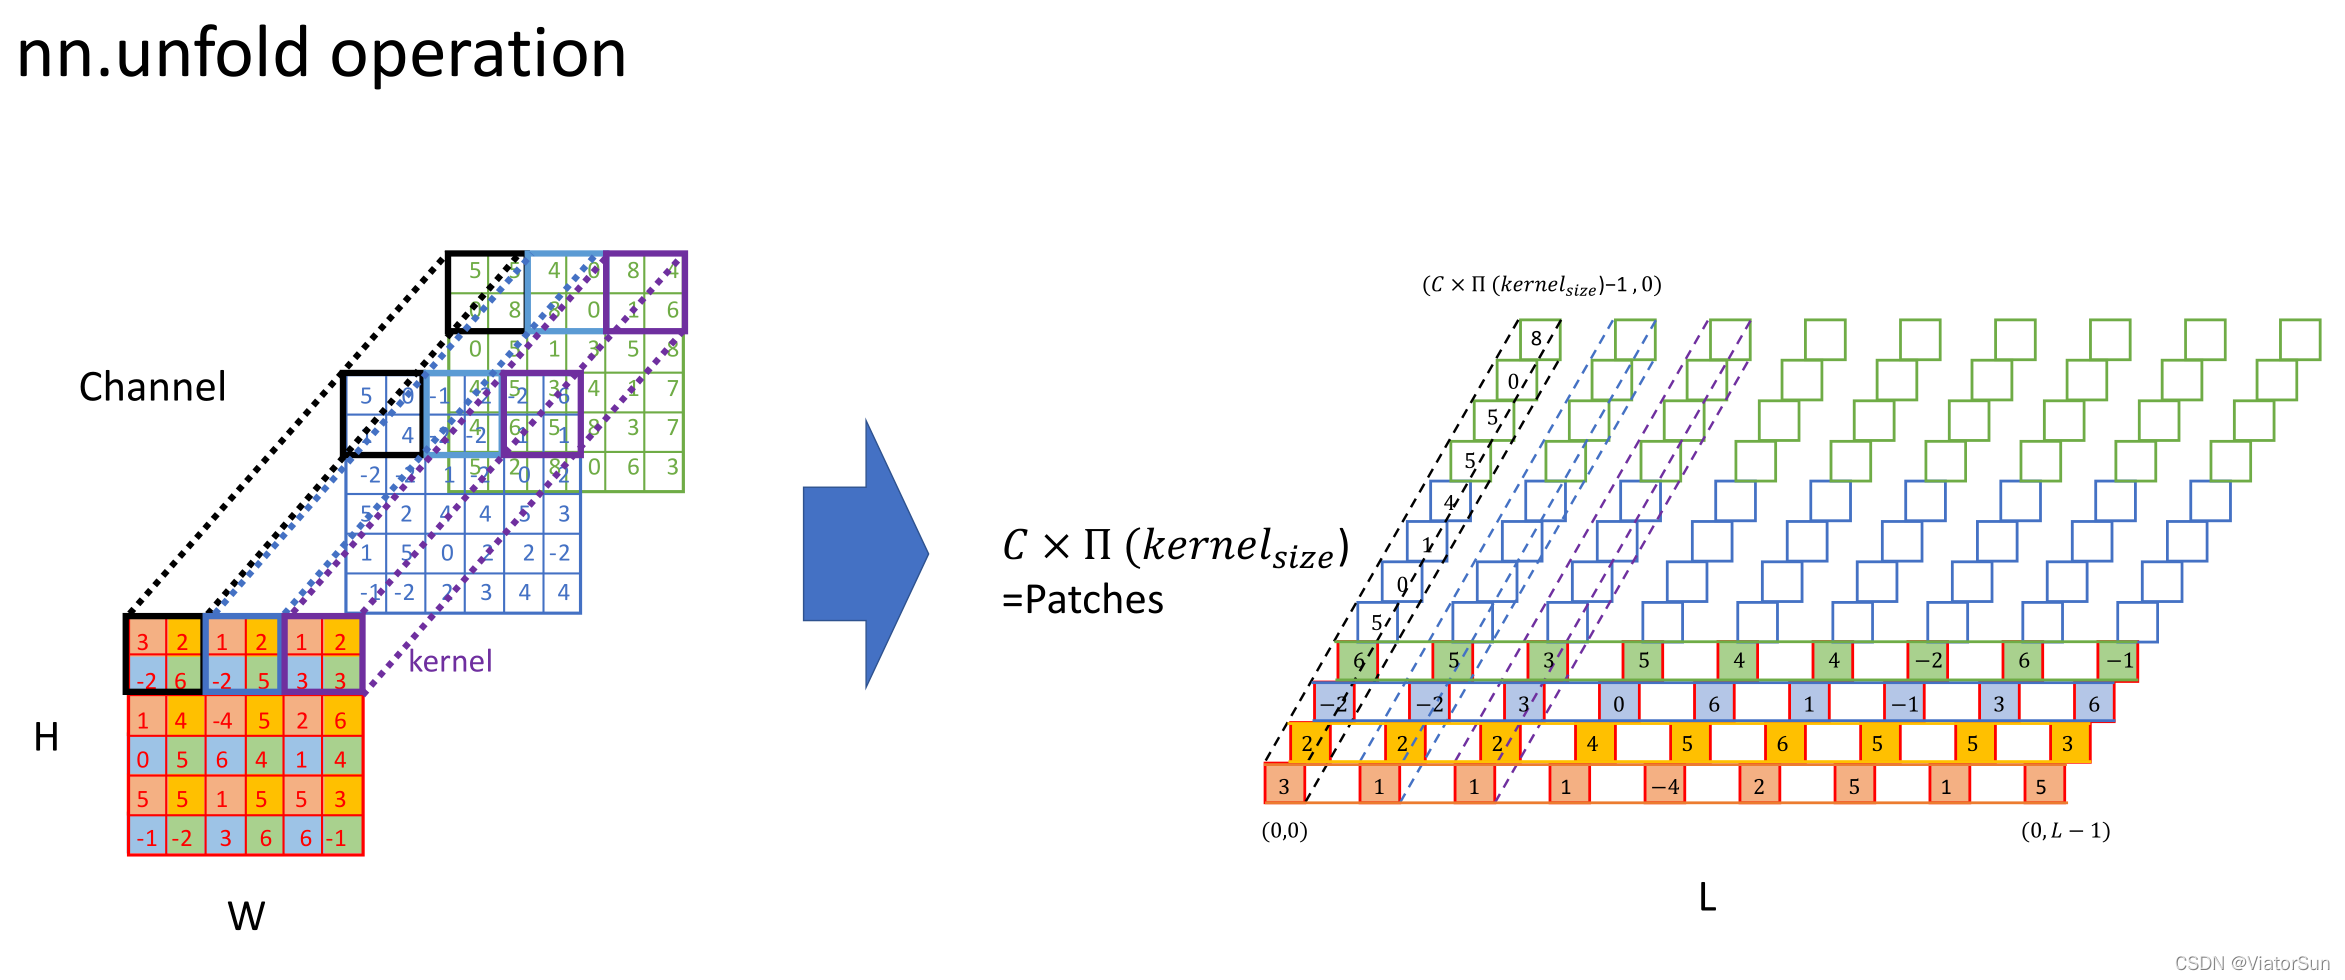
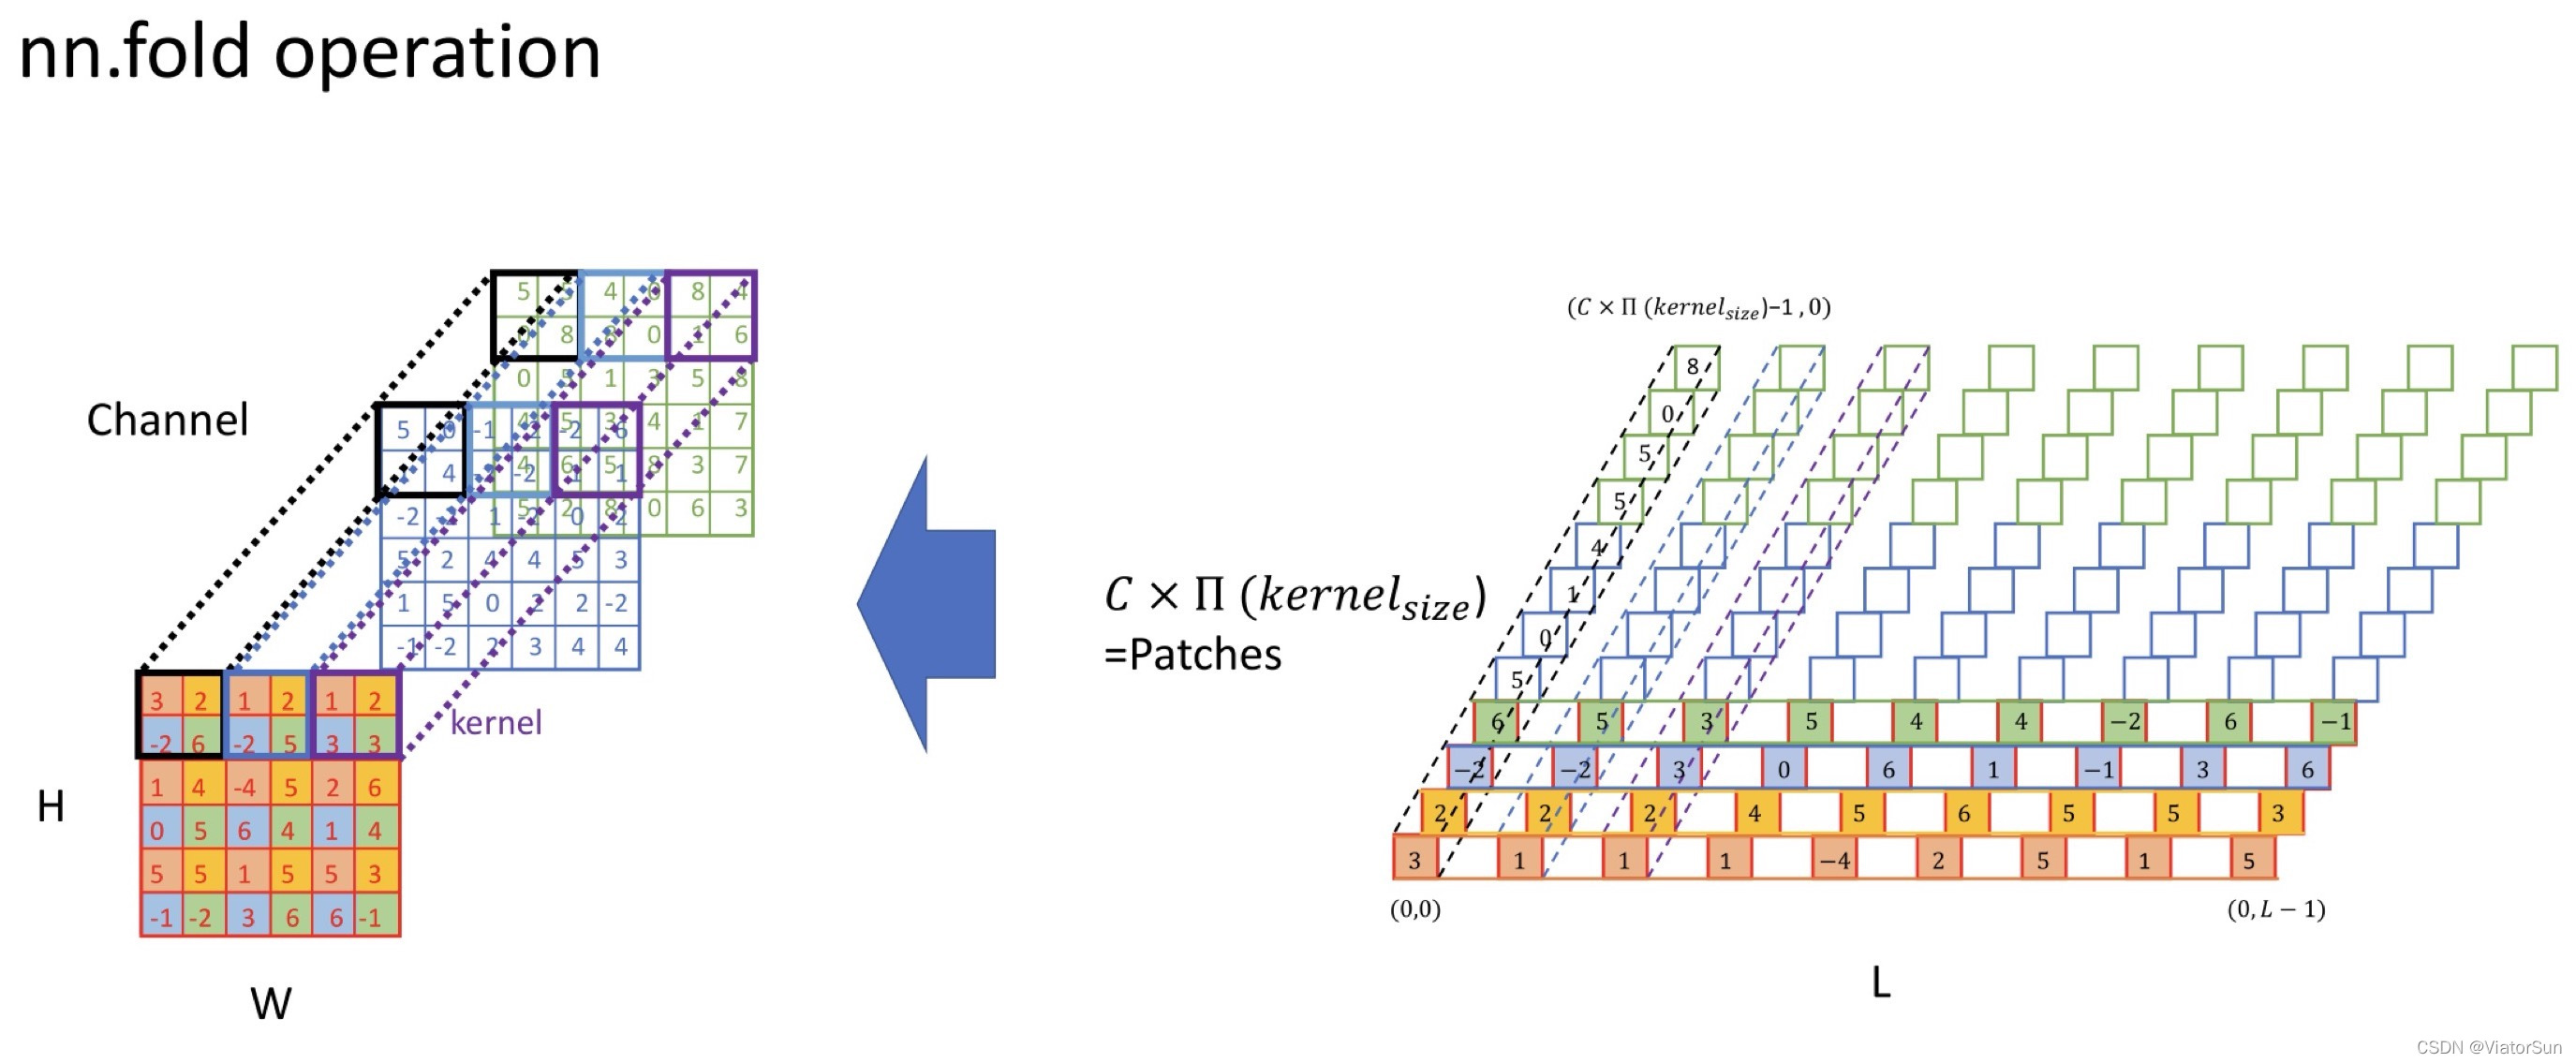
</div>

### 1）卷积层详解

#### 1、实例化需要的参数
以2d为例：torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

##### Conv2d改变了数据维度（N,C,H,W）中的C,H,W三个值，在输入数据的维度一定的情况下，其中C由卷积核的个数决定，H,W由卷积核的尺寸决定。
##### 重要参数：
##### in_channels：输入数据的channel维度，也就是数据的通道数，对于带batch_size维度的照片来说，数据的维度一半是（N,C,H,W）,这里的C就是in_channels的值
##### out_channels：输出数据的channel维度，同时也是这一层卷积核的个数。
##### kernel_size：卷积核的尺寸，输入一个整数c或一个元组（h,w），则自动复制成(c,c)
##### stride=1：卷积核移动的步长
##### padding=0：填充值
##### dilation=1：卷积核内部每个子核和子核之间的距离，下图表达的是dilation=2的情况
<div>
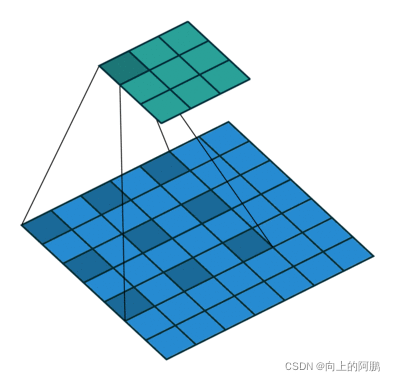
</div>

##### groups=1: 将输入数据的in_channel分成几组
<div>
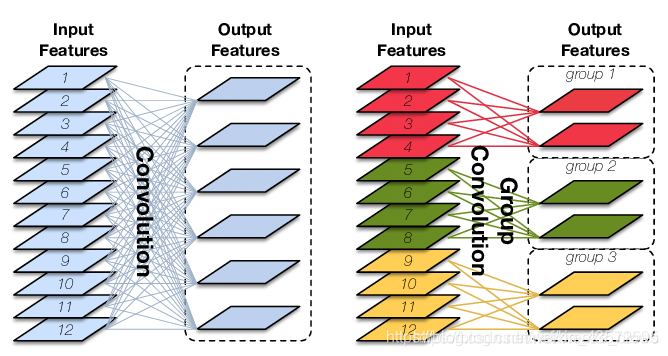
</div>

#### 2、模型中的权重、偏置等参数是按照什么原则初始化的
对于conv2d，查看官方的源代码可以发现如下线索：首先，Conv2d类自身并没有初始化权重和偏置的代码，而它继承自_ConvNd类，而其他的Conv类也继承自这个_ConvNd类。查看_ConvNd类的源码，在__init__()构造函数中，发现有如下跟weight和bias相关的代码：    
##### 可以看到weight和bias生成的过程是，先在\__init__()中传进来的input_data的in和out_channels的维度创建空的tensor，然后将空的tensor传给nn.Paramter()实例化出模型可以迭代的模型参数。然后通过reset_paramters对上一步生成的模型参数进行初始化，初始化使用的方法是init.kaiming_uniform_(self.weight, a=math.sqrt(5))。
```python
class _ConvNd(Module):
    …………
    def __init__(self,……):
        ……
        if transposed:
            self.weight = Parameter(torch.empty(
                (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
        else:
            self.weight = Parameter(torch.empty(
                (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)
```

#### 3、如何将模型的参数初始化成自己想要的情况

我们可以通过init的其他方法对已经生成的模型的参数进行再一次初始化，以满足我们对初始化参数的要求，大致代码如下：

##### 第一种用torch.nn.apply()方法
```python
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1), 
            nn.ReLU(True),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.ReLU(True),
            nn.Linear(n_hidden_2, out_dim)
            
             )    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
 
 # 1. 根据网络层的不同定义不同的初始化方式     
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
     # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
# 2. 初始化网络结构        
model = Net(in_dim, n_hidden_1, n_hidden_2, out_dim)
# 3. 将weight_init应用在子模块上
model.apply(weight_init)
#torch中的apply函数通过可以不断遍历model的各个模块。实际上其使用的是深度优先算法
```

##### 第二种用self.modules()方法来循环
```python
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1), 
            nn.ReLU(True),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.ReLU(True),
            nn.Linear(n_hidden_2, out_dim)
            
             )    
       for m in self.modules():
             if isinstance(m, nn.Conv2d):
                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
             elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                 nn.init.constant_(m.weight, 1)
                 nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
```

#### 2）池化层（Pooling layers）：
MaxPool1d/2d/3d
###### 最大池化，需要指定核的尺寸，步长等数据才能初始化
MaxUnpool1d/2d/3d
###### 最大池化的反向过程
<div>
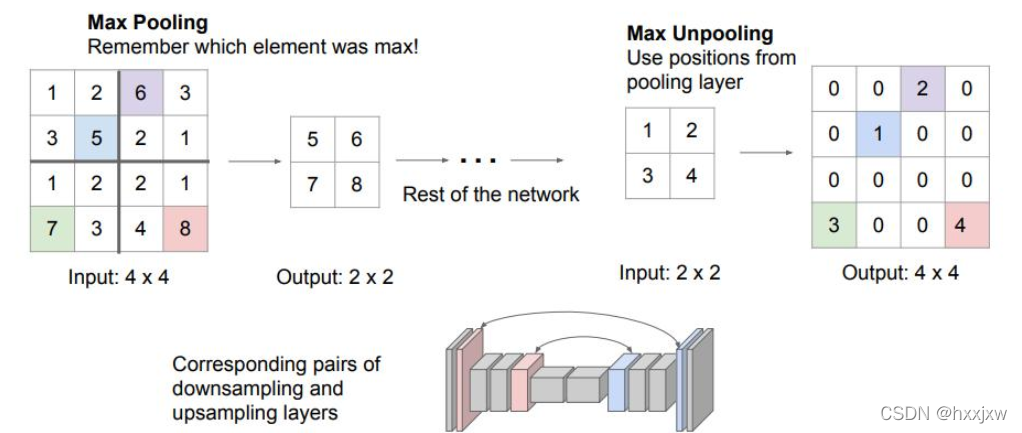
</div>

AvgPool1d/2d/3d
###### 平均池化
FractionalMaxPool2d/3d
###### 分数最大池化，输入与输出维度比例不成整数比，通过随机池化核的大小来实现输入与输出维度不成整数比。只需要指定核尺寸和输出尺寸。指定的核尺寸为最大的核尺寸，实际过程中某些步可能会使用比指定核尺寸小的核来池化
LPPool1d/2d(n,kernel_size, stride=None, ceil_mode=False)
###### 求核内每个元素n次幂的和的n次方作为池化的结果，n需要通过参数指定
AdaptiveAvg/MaxPool1d/2d/3d
###### 给的输出维度中的h,w或者其中一个，不管输入的数据w,h是什么维度的，都可以按照指定输出维度输出。无需计算和指定池化核大小、步长等数据。可以用来处理卷积层和全连接层的数据维度需要通过繁琐的计算才能匹配的情况，使用这个池化层可以不用过多的考虑卷积层和全连接层的维度关系


In [16]:
#自适应池化官网例子
import torch
# target output size of 5x7
m = nn.AdaptiveMaxPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)
# target output size of 7x7 (square)
m = nn.AdaptiveMaxPool2d(7)
input = torch.randn(1, 64, 10, 9)
output = m(input)
print(output.shape)
# target output size of 10x7
m = nn.AdaptiveMaxPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)
print(output.shape)

torch.Size([1, 64, 5, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 10, 7])


#### 3）填充层（Padding Layers）：
##### ReflectionPad1d/2d/3d
###### 以原数据的边界为轴反射对应的值到增加的位置上。传递一个int或者一个包含四个元素的tuple作为参数

In [17]:
#反射填充官网例子：
import torch.nn as nn
m = nn.ReflectionPad2d(2)
input = torch.arange(9, dtype=torch.float).reshape(1, 1, 3, 3)
print('原始tensor：\n',input)
print('\nReflectionPad2d(2):\n',m(input))
# using different paddings for different sides
m = nn.ReflectionPad2d((1, 1, 2, 0))
print('\nReflectionPad2d((1, 1, 2, 0)):\n',m(input))

原始tensor：
 tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])

ReflectionPad2d(2):
 tensor([[[[8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.],
          [5., 4., 3., 4., 5., 4., 3.],
          [8., 7., 6., 7., 8., 7., 6.],
          [5., 4., 3., 4., 5., 4., 3.],
          [2., 1., 0., 1., 2., 1., 0.]]]])

ReflectionPad2d((1, 1, 2, 0)):
 tensor([[[[7., 6., 7., 8., 7.],
          [4., 3., 4., 5., 4.],
          [1., 0., 1., 2., 1.],
          [4., 3., 4., 5., 4.],
          [7., 6., 7., 8., 7.]]]])


##### ReplicationPad1d/2d/3d
###### 新增加的位置的值复制距离位置最近的原始数据，数据传递同上

In [18]:
#复制填充官网例子：
import torch.nn as nn
m = nn.ReplicationPad2d(2)
input = torch.arange(9, dtype=torch.float).reshape(1, 1, 3, 3)
print('原始tensor：\n',input)
print('\nReplicationPad2d(2):\n',m(input))
# using different paddings for different sides
m = nn.ReplicationPad2d((1, 1, 2, 0))
print('\nReplicationPad2d((1, 1, 2, 0)):\n',m(input))

原始tensor：
 tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])

ReplicationPad2d(2):
 tensor([[[[0., 0., 0., 1., 2., 2., 2.],
          [0., 0., 0., 1., 2., 2., 2.],
          [0., 0., 0., 1., 2., 2., 2.],
          [3., 3., 3., 4., 5., 5., 5.],
          [6., 6., 6., 7., 8., 8., 8.],
          [6., 6., 6., 7., 8., 8., 8.],
          [6., 6., 6., 7., 8., 8., 8.]]]])

ReplicationPad2d((1, 1, 2, 0)):
 tensor([[[[0., 0., 1., 2., 2.],
          [0., 0., 1., 2., 2.],
          [0., 0., 1., 2., 2.],
          [3., 3., 4., 5., 5.],
          [6., 6., 7., 8., 8.]]]])


##### ZeroPad2d
###### 用0来补充新增位置的值。数据传递同上
##### ConstantPad1d/2d/3d
###### 用常数来补充新增位置的值。数据传递同上


#### 4）激活层（不进行归一化的激活层，除了各种softmax之外的sigmoid，ReLU这些）（Non-linear Activations (weighted sum, nonlinearity)）：
##### ReLU
###### max(0,x)
##### Sigmoid
###### 1/(1+exp(-x))
##### Tanh 
###### (exp(x)-exp(-x))/(exp(x)+exp(-x))
##### 其他待补充……

#### 5）激活层（进行归一化，各种softmax）（Non-linear Activations (weighted sum, nonlinearity)(others)）：
##### Softmax
###### exp(x_i)/sum(exp(x_j))

#### 6）标准处理层（Normalization Layers）：
#### 7）循环层（Recurrent Layers）：
#### 8）Transformer Layers（主要是encoder和decoder，seq2seq里的那些东西）：

#### 9）线性层（Linear Layers）：
##### Linear
###### 需要传入输入数据特征维度，和输出数据特征维度作为参数。

#### 10）Dropout Layers：

#### 11）Sparse Layers（主要是embedding层和类似的）：

#### 12）距离相关函数（Distance Functions，余弦相似度等）：
##### CosineSimilarity

#### 13）损失函数（Loss Functions）：
##### L1Loss
##### MSELoss
##### CrossEntropyLoss

#### ……还有一些其他类别，以后再补充……